# EECE5644 Final Project (jarrod Version)
## Image Classification of Mars Curiosity Rover 
### Ethan Holand and Jarrod Homer
***
Data retrieved from https://data.nasa.gov/Space-Science/Mars-surface-image-Curiosity-rover-labeled-data-se/cjex-ucks

In [137]:
import matplotlib.pyplot as plt # For general plotting

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold # Important new include

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

# from torchsampler import ImbalancedDatasetSampler

import seaborn as sns # for pretty plots

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
random_seed = 7
np.random.seed(random_seed)
torch.manual_seed(random_seed)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [138]:
# Sets code to run on cpu or gpu, depending on what is available:
# In testing, GPU accel improves performance tenfold
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), array([  37,    8,   12,   73,   31,  405,    5,   10, 1944,  239,  209,
         11,   48,   29,   84,   79,   30,  102,   16,   26,   46,  152,
        154,  558], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), array([  9,   2,   3,  19,   8, 101,   1,   2, 486,  60,  52,   3,  12,
         7,  21,  20,   8,  26,   4,   6,  11,  38,  39, 140], dtype=int64))
ground inlet mahli cal target ground ground wheel ground ground


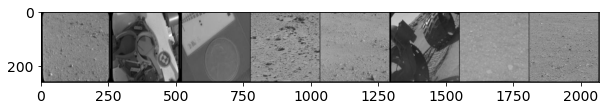

In [139]:
# Define how transform the data for processing in batches
transform = transforms.Compose([
        transforms.Resize([256,256]), # Resizing the image
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.0,0.0,0.0), std=(1.0,1.0,1.0)),
        transforms.Grayscale() # Converting images to grayscale
    ])

# Specify the batch size for SGD
batch_size = 64
# Use the ImageFolder class, which is a generic dataloder useful when images stored in labelled directories
# Apply transform to images specified above, importantly converting "ToTensor"
# test_dataset= torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\test', transform=transform)
# train_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\train', transform=transform)
# print("Dataset has {} training samples and {} test samples".format(len(train_dataset), len(test_dataset)))

##########################                              MAKE SURE PATH IS CORRECT
dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\train_and_valid', transform=transform)
# dataset = torchvision.datasets.ImageFolder(root=r'~/Downloads/EECE5644/Project/rearrangedFiles/train_and_valid', transform=transform)
# valid_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\valid', transform=transform)


# Specify classes for convenience in printing
classes = ('apxs', 'apxs cal target', 'chemcam cal target', 'chemin inlet open', 'drill', 'drill holes', 'drt front', 'drt side', 'ground', 'horizon', 'inlet', 'mahli', 'mahli cal target', 'mastcam', 'mastcam cal target', 'observation tray', 'portion box', 'portion tube', 'portion tube opening', 'rems uv sensor', 'rover rear deck', 'scoop', 'turret', 'wheel')

# List of targets/labels for entire dataset
targets = dataset.targets
# Use sklearn function to split the data into training-test sets (80-20 split)
# Stratified ensures that same percentage of samples of each target class form a complete set
train_idx, test_idx= train_test_split(
    np.arange(len(targets)), test_size=0.2, random_state=random_seed, shuffle=True, stratify=targets)

# Printing the unique class labels in each split set and the number of occurrences per class
print(np.unique(np.array(targets)[train_idx], return_counts=True))
print(np.unique(np.array(targets)[test_idx], return_counts=True))

# Create training and test subsets based on split indices
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Define iterable for our newly created dataset and shuffle samples 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)


### Plotting stuff ###
fig = plt.figure(figsize=(10,15))
# Utility function to show an image
def imshow(img):
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0))) #CHW to HWC (channels, height, width)

# Get some random training dataset images
dataiter = iter(train_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [140]:
# Code to find class weights. This could help the imbalanced dataset, but testing has shown otherwise
class_weights=class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(dataset.targets),y=dataset.targets)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
print(class_weights)

tensor([ 4.8786, 22.4417, 14.9611,  2.4393,  5.7543,  0.4435, 37.4028, 18.7014,
         0.0924,  0.7506,  0.8598, 16.0298,  3.7403,  6.2338,  2.1373,  2.2668,
         5.9057,  1.7533, 11.2208,  7.0130,  3.9371,  1.1811,  1.1628,  0.3215],
       device='cuda:0')


In [141]:
# Note that PyTorch uses NCHW (samples, channels, height, width) image format convention
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_filters, out_classes, kernel_size=3, stride=1, dropout=0.2):
        super().__init__()
        # Conv2D layer with 'same' padding so image retains shape
        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size, stride=stride, padding=stride)
        self.conv1_bn=nn.BatchNorm2d(num_filters) # NOTE New
        self.drop = nn.Dropout(p=dropout)
        #self.dropout = 
        # MaxPooling layer with 2x2 kernel size and stride 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size, stride=stride, padding=stride)
        self.conv2_bn=nn.BatchNorm2d(num_filters*2) # NOTE New
        
        self.fc1 = nn.Linear(num_filters*2*64*64, num_filters)
        self.fc2 = nn.Linear(num_filters, out_classes)

    def forward(self, x):
        x = x.to(device)
        # Non-linear ReLU activations between convolutional layers
        # Conv->ReLU->Pooling
        # 256x256 image -> 128x128 after pooling
        x = self.pool(self.drop(F.relu(self.conv1(x))))
        # 128x128 feature map -> 64x64 after pooling
        x = self.pool(self.drop(F.relu(self.conv2(x))))
        # Flatten all dimensions except batch (start_dim=1)
        x = torch.flatten(x, 1) # Prepares data from convolutional layers to fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [142]:
def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train().to(device)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction error
        predictions = model(X).to(device)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X=X.to(device)
            y=y.to(device)
            predictions = model(X).to(device)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum()
            
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return accuracy

In [143]:
def p_error(decisions, labels):
    print("Confusion Matrix (rows: Predicted class, columns: True class):")
    conf_mat = confusion_matrix(decisions, labels)
    print(conf_mat)

    correct_class_samples = np.sum(np.diag(conf_mat))
    print("Total Mumber of Misclassified Samples: {:d}".format(len(decisions) - correct_class_samples))

    prob_error = 1 - (correct_class_samples / len(decisions))
    print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))
    return prob_error

In [144]:
print("\nCV Running:")
#########################################################   Do CV
num_grid_pts=10


#use this for random floats
learning_rates = np.random.uniform(low=0.005, high=0.015, size=(num_grid_pts,))
filters = np.random.randint(low=16, high=32+1, size=num_grid_pts)
strides = 1
dropouts = np.random.uniform(low=0.15, high=0.25, size=(num_grid_pts,))

#filters = [16,32]
#n_nerons= len(filters)


# Number of folds for CV
K = 10

# STEP 1: Partition the dataset into K approximately-equal-sized partitions
# Shuffles data before doing the division into folds (not necessary, but a good idea)
kf = KFold(n_splits=K, shuffle=True) 

# Allocate space for CV
# No need for training loss storage too but useful comparison
error_valid_mk = np.empty((num_grid_pts, K)) 
error_train_mk = np.empty((num_grid_pts, K)) # Indexed by model m, data partition k

# STEP 2: Iterate through hyperparameter
nerind=0
while nerind <num_grid_pts:
    print("Learning Rate:{}, Num filters:{}, Strides:{}, dropouts:{}".format(learning_rates[nerind], filters[nerind], strides[nerind], dropouts[nerind]))
    # K-fold cross validation
    k = 0
    # NOTE that these subsets are of the TRAINING dataset
    # Imagine we don't have enough data available to afford another entirely separate validation set
    for train_indices, valid_indices in kf.split(train_dataset):
        # Extract the training and validation sets from the K-fold split


        # Create training and test subsets based on split indices
        cv_train_dataset = Subset(train_dataset, train_indices)
        cv_test_dataset = Subset(train_dataset, valid_indices)

        # Define iterable for our newly created dataset and shuffle samples 
        cv_train_dataloader = DataLoader(cv_train_dataset, batch_size=batch_size, shuffle=True)
        cv_test_dataloader = DataLoader(cv_test_dataset, batch_size=batch_size)
        # valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
        
        X_train_k_tensor, y_train_k_tensor = next(iter(cv_train_dataloader))
        X_valid_k_tensor, y_valid_k_tensor = next(iter(cv_test_dataloader))

        ############Do model stuff
        input_channels = images.shape[1]
        model = ConvNet(input_channels, num_filters=filters[nerind], out_classes=len(classes), stride=strides[nerind], dropout=dropouts[nerind]).to(device)
        summary(model, input_size=(input_channels, 256, 256))
        # The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to output
        criterion = nn.CrossEntropyLoss() #(weight=class_weights)
        num_epochs = 10
        # accuracies = np.zeros(num_epochs)

        ######### early stopping params
        last_loss = 0
        patience = 3
        trigger_times = 0
        done=False
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rates[nerind], momentum=0.9, nesterov=True)
        for t in range(num_epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            model_train_loader(model, cv_train_dataloader, criterion, optimizer)
            #accuracies[t] = model_test_loader(model, cv_test_dataloader, criterion)
            # model_test_loader(model, cv_test_dataloader, criterion)

            #########early stopping
            current_loss = model_test_loader(model, cv_test_dataloader, criterion)
            print('The Current Loss:', current_loss)

            if current_loss - last_loss < .1:
                trigger_times += 1
                print('Trigger Times:', trigger_times)

                if trigger_times >= patience:
                    print('Early stopping!\nStart to test process.')
                    print("######\n######\n#####\n#####")
                    done =True

            else:
                print('trigger times: 0')
                trigger_times = 0

            last_loss = current_loss
            if done:
                break
        ###finished training



        # Trained model
        Z_probs_train = model(X_train_k_tensor).cpu().detach().numpy()
        Z_pred_train = np.argmax(Z_probs_train, 1)

        Z_probs_valid = model(X_valid_k_tensor).cpu().detach().numpy()
        Z_pred_valid = np.argmax(Z_probs_valid, 1)

        # Record error as well for this model and k-fold
        error_train_mk[nerind, k] = p_error(Z_pred_train, y_train_k_tensor.cpu().numpy())
        error_valid_mk[nerind, k] = p_error(Z_pred_valid, y_valid_k_tensor.cpu().numpy())

        # ###########finish training stuff

        # mse_train_mk[n]
        

        # # Validation fold polynomial transformation

        # # validation set:
        # model_test_loader(model, cv_test_dataloader, criterion)
        


        k += 1

    nerind+=1
            
# STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
error_train_m = np.mean(error_train_mk, axis=1) 
error_valid_m = np.mean(error_valid_mk, axis=1) 


CV Running:
Learning Rate:0.005763082893739572, Num filters:19, Strides:1, dropouts:0.24779895119966028
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            190
├─BatchNorm2d: 1-2                       38
├─Dropout: 1-3                           --
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            6,536
├─BatchNorm2d: 1-6                       76
├─Linear: 1-7                            2,957,331
├─Linear: 1-8                            480
Total params: 2,964,651
Trainable params: 2,964,651
Non-trainable params: 0
Epoch 1
-------------------------------
loss: 3.265052  [    0/ 3446]
loss: 2.089872  [  640/ 3446]
loss: 1.865273  [ 1280/ 3446]
loss: 1.587054  [ 1920/ 3446]
loss: 1.320612  [ 2560/ 3446]
loss: 1.495597  [ 3200/ 3446]
Test Error: 
 Accuracy: 64.5%, Avg loss: 1.552068 

The Current Loss: tensor(64.5012, device='cuda:0')
trigger times: 0
Epoch 2
-------------------------------
loss: 1.350648  [    0/ 34

In [145]:
print(error_valid_m)
best_grid_pt=np.argmin(error_valid_m)
print(best_grid_pt)

[0.240625 0.309375]
0


In [146]:
##############                  Retrain on best params
# List of targets/labels for entire dataset
# targets = dataset.targets
# # Use sklearn function to split the data into training-test sets (80-20 split)
# # Stratified ensures that same percentage of samples of each target class form a complete set
# train_idx, test_idx= train_test_split(
#     np.arange(len(targets)), test_size=0.2, random_state=random_seed, shuffle=True, stratify=targets)

# # Printing the unique class labels in each split set and the number of occurrences per class
# print(np.unique(np.array(targets)[train_idx], return_counts=True))
# print(np.unique(np.array(targets)[test_idx], return_counts=True))

# # Create training and test subsets based on split indices
# train_dataset = Subset(dataset, train_idx)
# test_dataset = Subset(dataset, test_idx)

# Define iterable for our newly created dataset and shuffle samples 
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

############Do model stuff
input_channels = images.shape[1]
model = ConvNet(input_channels, num_filters=filters[best_grid_pt], out_classes=len(classes), stride=strides[best_grid_pt], dropout=dropouts[best_grid_pt]).to(device)
summary(model, input_size=(input_channels, 256, 256))
# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to output
criterion = nn.CrossEntropyLoss() #(weight=class_weights)
num_epochs = 10

######### early stopping params
last_loss = 0
patience = 3
trigger_times = 0
done=False
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rates[best_grid_pt], momentum=0.9, nesterov=True)

accuracies = np.zeros(num_epochs)

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train_loader(model, train_dataloader, criterion, optimizer)
    # accuracies[t] = model_test_loader(model, test_dataloader, criterion)

    #########early stopping
    current_loss = model_test_loader(model, test_dataloader, criterion)
    accuracies[t] = current_loss
    print('The Current Loss:', current_loss)

    if current_loss - last_loss < .1:
        trigger_times += 1
        print('Trigger Times:', trigger_times)

        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            print("######\n######\n#####\n#####")
            done =True

    else:
        print('trigger times: 0')
        trigger_times = 0

    last_loss = current_loss
    if done:
        break
###finished training

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            190
├─BatchNorm2d: 1-2                       38
├─Dropout: 1-3                           --
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            6,536
├─BatchNorm2d: 1-6                       76
├─Linear: 1-7                            2,957,331
├─Linear: 1-8                            480
Total params: 2,964,651
Trainable params: 2,964,651
Non-trainable params: 0
Epoch 1
-------------------------------
loss: 3.088023  [    0/ 4308]
loss: 1.943480  [  640/ 4308]
loss: 1.738504  [ 1280/ 4308]
loss: 1.285664  [ 1920/ 4308]
loss: 1.319063  [ 2560/ 4308]
loss: 1.497191  [ 3200/ 4308]
loss: 1.106887  [ 3840/ 4308]
Test Error: 
 Accuracy: 74.6%, Avg loss: 1.320101 

The Current Loss: tensor(74.5826, device='cuda:0')
trigger times: 0
Epoch 2
-------------------------------
loss: 1.186363  [    0/ 4308]
loss: 1.160874  [  640/ 4308]
loss: 1.230256  [ 1280/ 4308]
loss: 0.896

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


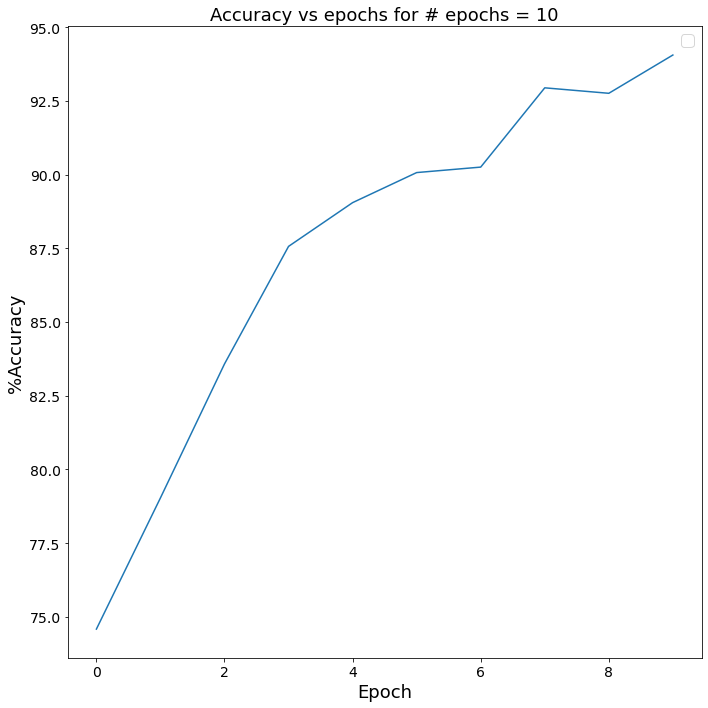

In [147]:
# # Plot MSE vs degree
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.plot(nerons, error_train_m, color="b", marker="s", label=r"$D_{train}$")
# ax.plot(nerons, error_valid_m, color="r", marker="x", label=r"$D_{valid}$")


# ax.legend(loc='upper left', shadow=True)
# plt.xlabel("Number of Channels")
# plt.ylabel("Probability of error")
# plt.show()



# Plot accuracies over epochs:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(num_epochs), accuracies)
plt.title("Accuracy vs epochs for # epochs = {}".format(num_epochs))
plt.legend()
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('%Accuracy')
plt.show()

GroundTruth:  ground scoop horizon inlet mastcam cal target wheel horizon ground drill holes wheel mastcam cal target ground wheel ground ground drill holes wheel inlet ground wheel ground ground wheel portion tube portion tube ground drill holes horizon drill holes wheel wheel drill holes ground wheel wheel ground drill holes portion box ground wheel rover rear deck ground ground ground ground ground wheel ground ground drill holes ground wheel inlet drill holes ground ground ground ground mahli wheel ground ground ground ground
Predicted:  ground scoop horizon inlet mastcam cal target wheel horizon ground drill holes wheel mastcam cal target ground wheel ground ground drill holes wheel inlet ground wheel ground ground wheel portion tube portion tube ground drill holes ground drill holes wheel wheel drill holes ground wheel wheel ground drill holes portion box ground wheel rover rear deck ground ground ground ground ground wheel ground ground drill holes ground wheel inlet drill holes

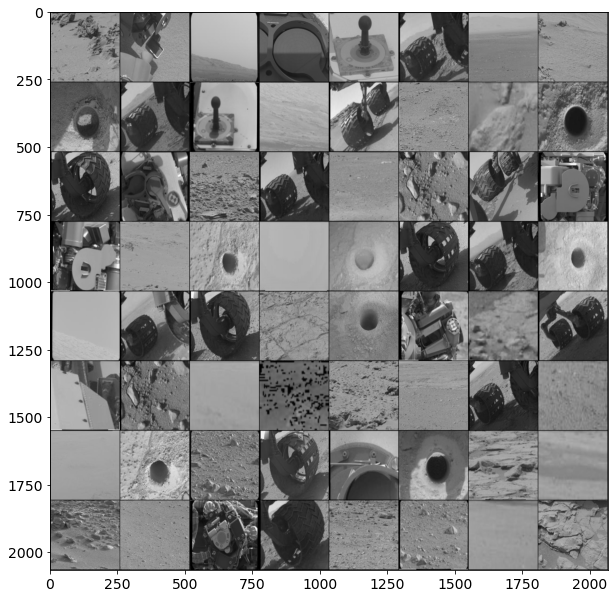

In [148]:
### Plotting stuff ###
fig = plt.figure(figsize=(10,15))

# Get some random test dataset images
dataiter = iter(test_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:64]))
# Print labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

outputs = model(images).to(device)
# Argmax take the most probable class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(64)))

In [149]:
## Apply model to entire dataset
# Now that we have trained our model, we want to analyze the results across the entire dataset
# Code to iterate through entire dataset adapted from https://deeplizard.com/learn/video/0LhiS6yu2qQ
# This is necessary as most computers do not have enough memory to run the model on the entire dataset all at once

@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device) # Creates empty tensor to store predictions 
    all_labels = torch.tensor([]).to(device) # Creates empty tensor to store labels
    for batch in loader: # Iterate through each batch:
        images, labels = batch # Get the images and labels for each batch

        init_preds = model(images).to(device) # run into the model to get the predictions an image is in each class
        _, preds = torch.max(init_preds, 1) # choose the class with the highest likelihood

        # Append to predictions matrix:
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )

        # Append to labels matrix:
        labels = labels.to(device) #add it to gpu for calculation compatiblity
        all_labels = torch.cat(
                    (all_labels, labels)
                    ,dim=0
                )

    return all_preds, all_labels

with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64) # input the dataset and the batch size
    train_preds, all_labels = get_all_preds(model, prediction_loader) # apply the model to the loader, return outputs

<AxesSubplot:>

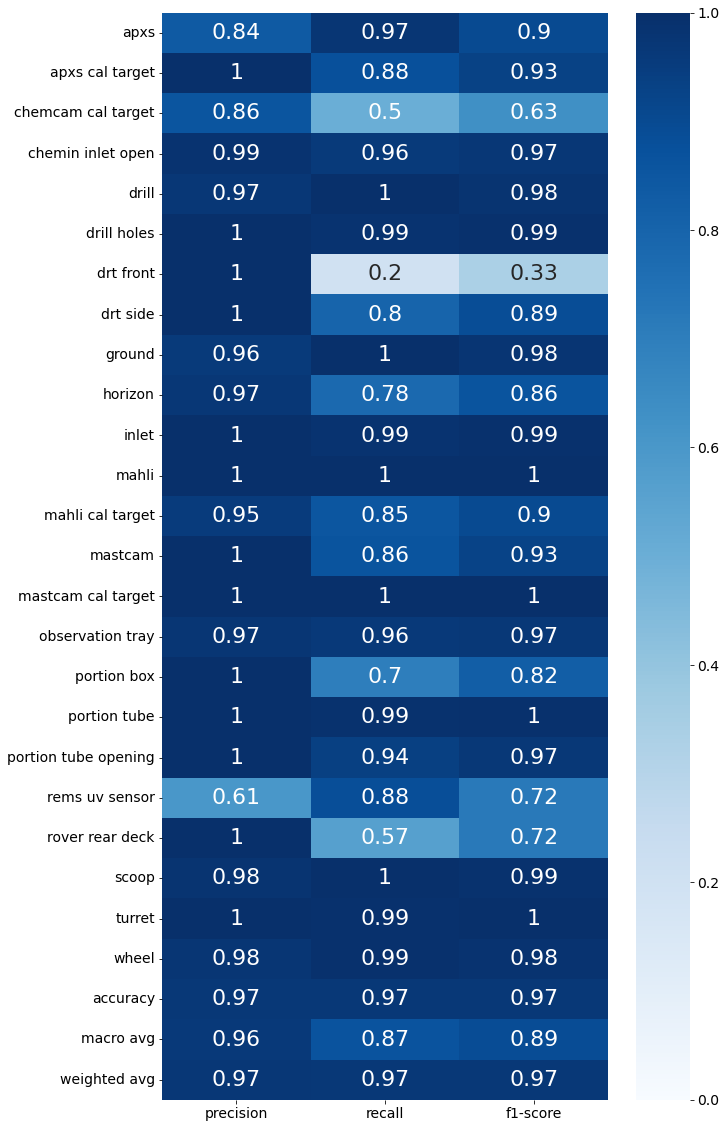

In [150]:
## Print classification report
# Using the SKlearn classification report function to return important metrics that will gauge the performance of the model.
# From https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html:
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label a negative sample as positive.
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives
# The recall is intuitively the ability of the classifier to find all the positive samples.
# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
# The support is the number of occurrences of each class in y_true.
report = classification_report(all_labels.to('cpu'), train_preds.to('cpu'), target_names=classes, output_dict=True)

import pandas as pd

fig = plt.figure(figsize=(10, 20)) # Larger figure to read text
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="Blues", vmin=0, vmax=1)


Text(0.5, 1.0, 'Confusion Matrix')

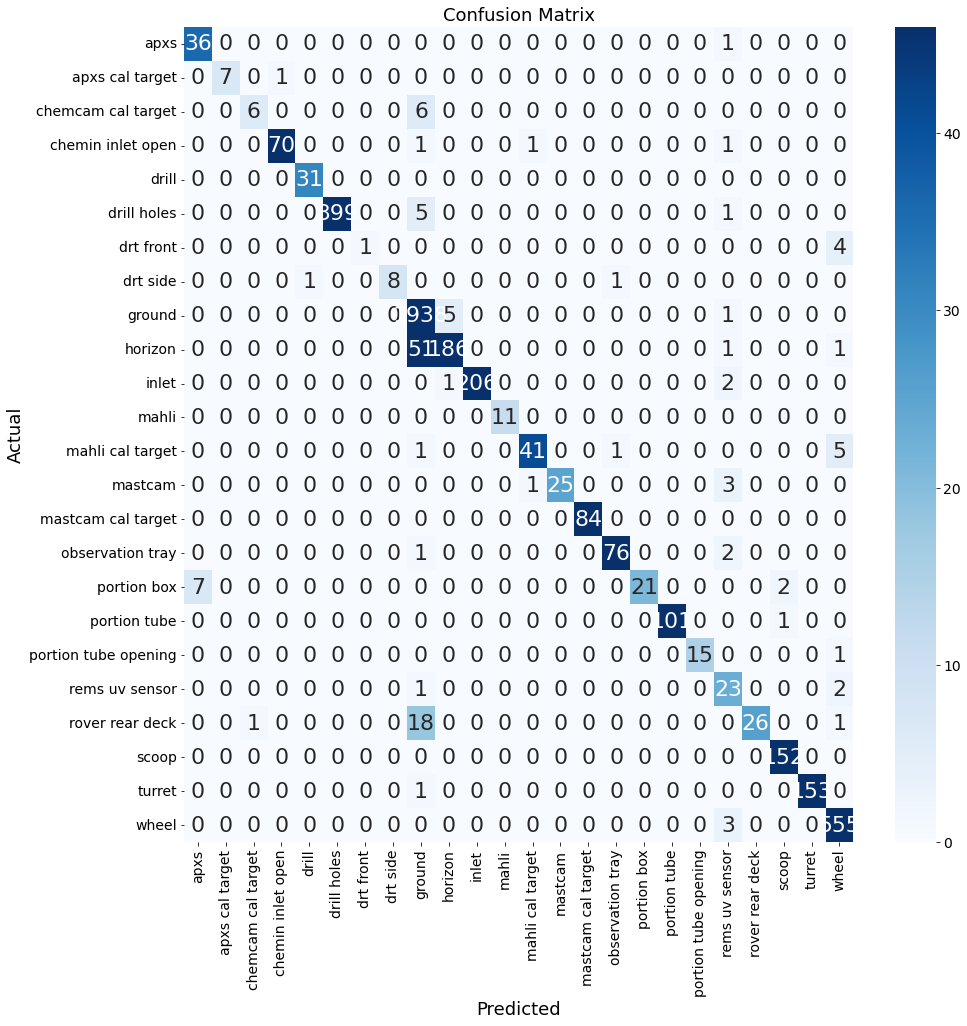

In [151]:
## Plot confusion matrix
# Actual vs predicted quantities for each label

cf_matrix = confusion_matrix(all_labels.to('cpu'), train_preds.to('cpu')) # Returns matrix of confusion matrix
fig = plt.figure(figsize=(15, 15)) # Larger figure to read text
sns.heatmap(cf_matrix, cmap="Blues", annot=True, fmt="g", xticklabels=classes, yticklabels=classes, robust=True) # Plots confusion matrix
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix') # Add titles, labels